In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [12]:
words = open('../data/names.txt', 'r').read().splitlines()

In [13]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
chtoi = {ch:i+1 for i, ch in enumerate(chars)}
chtoi['.'] = 0
itoch = {i:ch for ch, i in chtoi.items()}
vocab_size = len(itoch)
print(itoch)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = chtoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xval, Yval = build_dataset(words[n1:n2])   # 10%
Xtest,  Ytest  = build_dataset(words[n2:])     # 10%

torch.Size([182674, 3]) torch.Size([182674])
torch.Size([22671, 3]) torch.Size([22671])
torch.Size([22801, 3]) torch.Size([22801])


In [15]:
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) 
    B2 = torch.randn(vocab_size)

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2


In [45]:
def train(n_iters, lr, lossi, batch_size=32):
    for i in range(n_iters):
        
        # creating mini batch
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb] # embed characters to vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        hpreact = embcat @ W1 + B1 # hidden layer pre-activation 
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Yb)

        params = [C, W1, B1, W2, B2]

        # backward pass
        for p in params:
            p.grad = None
        loss.backward()

        #update params
        for p in params:
            p.data += -lr * p.grad 

        # track stats
        if i % 10_000 == 0: # print loss every 10k steps
            print(f'step {i:7d} of {n_iters:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item()) # keeping track of log10 of losses

    return lossi    

In [31]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [32]:
def sample(n_samples=20):
    for _ in range(20):
        out = []
        context = [0] * block_size # init context with all dots ...
        while True:
            emb = C[torch.tensor([context])] # (1, block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + B1)
            logits = h @ W2 + B2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(itoch[i] for i in out))    

In [46]:
C, W1, B1, W2, B2 = init_params()

11897


In [47]:
lossi = []
lossi = train(n_iters=50_000, lossi=lossi, lr=0.1)

step       0 of   50000: 26.0871
step   10000 of   50000: 2.7375
step   20000 of   50000: 2.3294
step   30000 of   50000: 2.3164
step   40000 of   50000: 2.4084


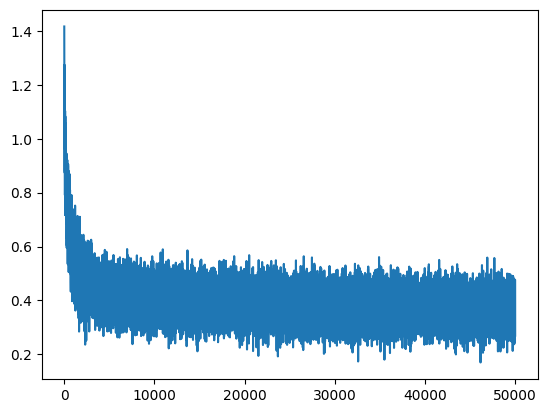

In [48]:
plt.plot(lossi)

In [50]:
split_loss('train')
split_loss('val')

train 2.381133556365967
val 2.424038887023926


In [51]:
sample()

emmeen.
ayaenni.
yani.
men.
caleiga.
amailo.
cayley.
finis.
amee.
gaeme.
fide.
noere.
aden.
ne.
nateste.
jazeellie.
vane.
lelu.
aagugneea.
kenn.


## Fixing Initialization Loss

Our initial loss is very high which then rapidly falls, this shows that the initialization isn't proper because the loss is too high. When training Neural Nets we almost always have some idea of what loss to expect at initialization.

At initialization, all characters have the same probability i.e. the probability distribution is uniform across all characters.

In [55]:
# prob for any character will be
p = torch.tensor(1 / 27.0)
loss  = -p.log()
loss

tensor(3.2958)

The initial loss expected is 3.29 which is much lower than what our first iteration has. The reason is at initialization the network is creating a random probability distribution in which some characters are very confident and some aren't which leads to the network being very confidently wrong.

In [56]:
# updating init function
def init_params(n_embed=10, n_hidden=200, vocab_size=27, block_size=3):
    C  = torch.randn((vocab_size, n_embed))
    W1 = torch.randn((n_embed * block_size, n_hidden))
    B1 = torch.randn(n_hidden)
    W2 = torch.randn((n_hidden, vocab_size)) * 0.01 
    B2 = torch.randn(vocab_size) * 0

    params = [C, W1, B1, W2, B2]
    print(sum(p.nelement() for p in params)) 
    
    for p in params:
      p.requires_grad = True

    return C, W1, B1, W2, B2

- We have updated `B2` to be 0 because in order to bring them as close as possible to 0, we don't want to add anything to the `logits` initially.
- We have added a scale down factor of 0.01 to `W2` for the same reason that we don't want our initial values to multiply with high random numbers.

Training with our updated initialization:

In [57]:
C, W1, B1, W2, B2 = init_params()
lossi = []
lossi = train(n_iters=100_000, lossi=lossi, lr=0.1)
split_loss('train')
split_loss('val')

11897
step       0 of  100000: 3.3016
step   10000 of  100000: 2.3679
step   20000 of  100000: 2.4875
step   30000 of  100000: 2.3006
step   40000 of  100000: 2.1612
step   50000 of  100000: 1.7421
step   60000 of  100000: 2.1352
step   70000 of  100000: 1.8505
step   80000 of  100000: 2.5637
step   90000 of  100000: 2.4055
train 2.2041075229644775
val 2.28027606010437


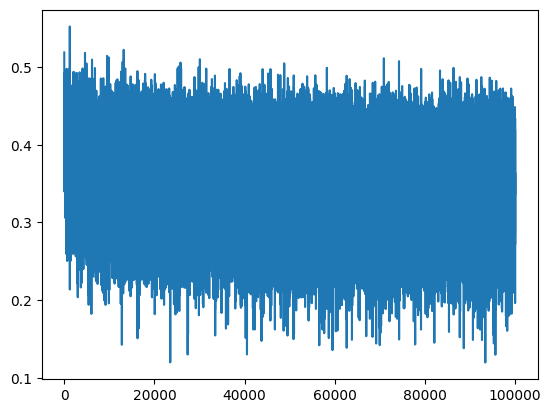

In [58]:
plt.plot(lossi)

Our initial loss has become very close to what we expect which can be seen in our plot of the loss which doesn't have the hockey shape appearance anymore.

Because of a better initialization the network has more cycles to actually optimize itself actually instead of spending the first few iteration to just squash the weights to bring them down from high random values.